<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Resnet50_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor



# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Loading the Training Data

In [6]:
print(type(df_data['target'].iloc[0]))


<class 'str'>


In [7]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into training and validation sets
train_df, val_df = train_test_split(df_data, test_size=0.2, random_state=123)


# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

def load_and_prepare_dataset(csv_path, images_dir, shuffle=True, batch_size=32):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
train_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/Training Images/', shuffle=True, batch_size=16)
val_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/Training Images/', shuffle=False, batch_size=16)


In [8]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

size of training dataset:  799
size of validation dataset:  799


# Visualising the training and validation datasets




Training dataset
(16, 224, 224, 3)
(16, 8)


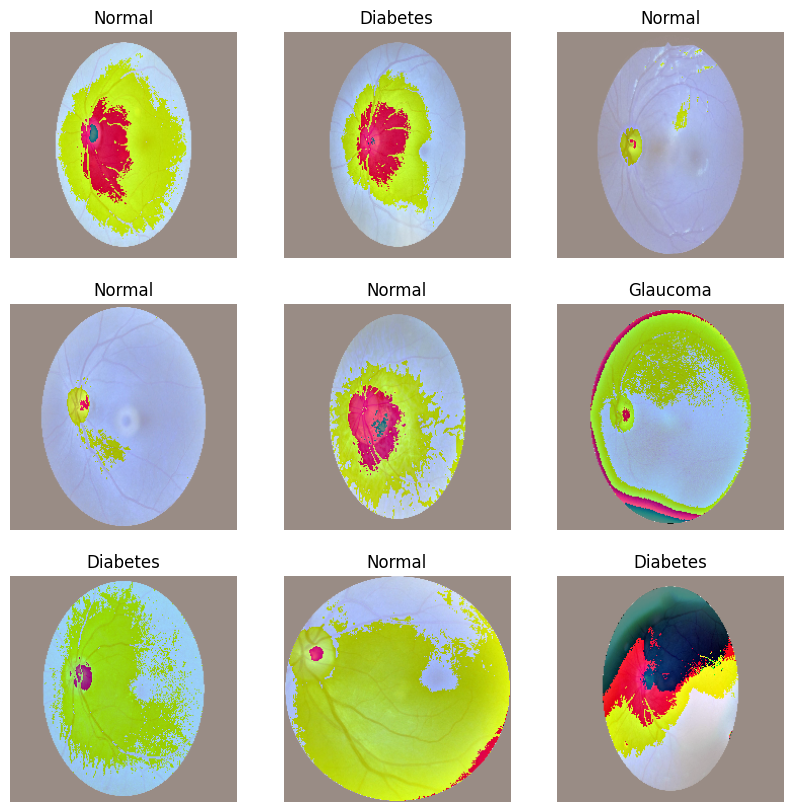

In [9]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(16, 224, 224, 3)
(16, 8)


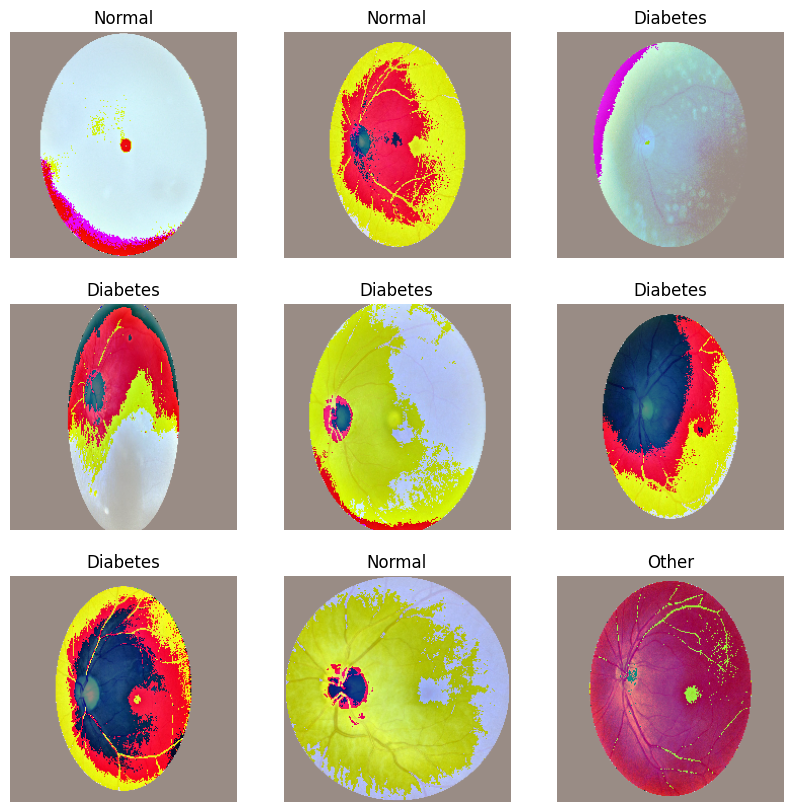

In [10]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

In [12]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [13]:
resnet_50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [14]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
epochs = 10
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
799/799 [==============================] - 111s 98ms/step - loss: 1.3395 - accuracy: 0.5086 - val_loss: 1.1804 - val_accuracy: 0.5554
Epoch 2/10
799/799 [==============================] - 104s 98ms/step - loss: 1.1951 - accuracy: 0.5451 - val_loss: 1.1472 - val_accuracy: 0.5583
Epoch 3/10
799/799 [==============================] - 102s 96ms/step - loss: 1.1434 - accuracy: 0.5695 - val_loss: 1.1245 - val_accuracy: 0.5892
Epoch 4/10
799/799 [==============================] - 101s 95ms/step - loss: 1.1037 - accuracy: 0.5801 - val_loss: 1.0822 - val_accuracy: 0.5983
Epoch 5/10
799/799 [==============================] - 101s 95ms/step - loss: 1.0624 - accuracy: 0.5940 - val_loss: 1.0050 - val_accuracy: 0.6061
Epoch 6/10
799/799 [==============================] - 101s 95ms/step - loss: 1.0255 - accuracy: 0.6065 - val_loss: 0.9770 - val_accuracy: 0.6191
Epoch 7/10
799/799 [==============================] - 103s 97ms/step - loss: 0.9894 - accuracy: 0.6166 - val_loss: 0.9576 - val_ac

# Evaluating Model
- Model Accuracy
- Model Loss


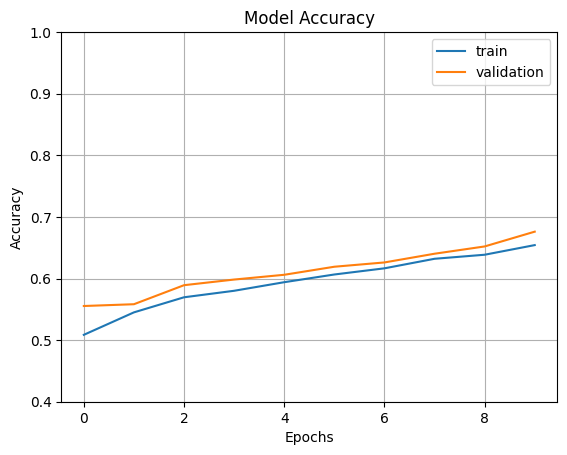

In [25]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

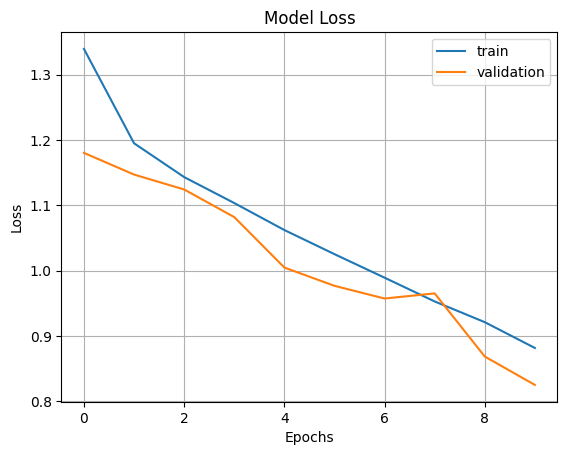

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data

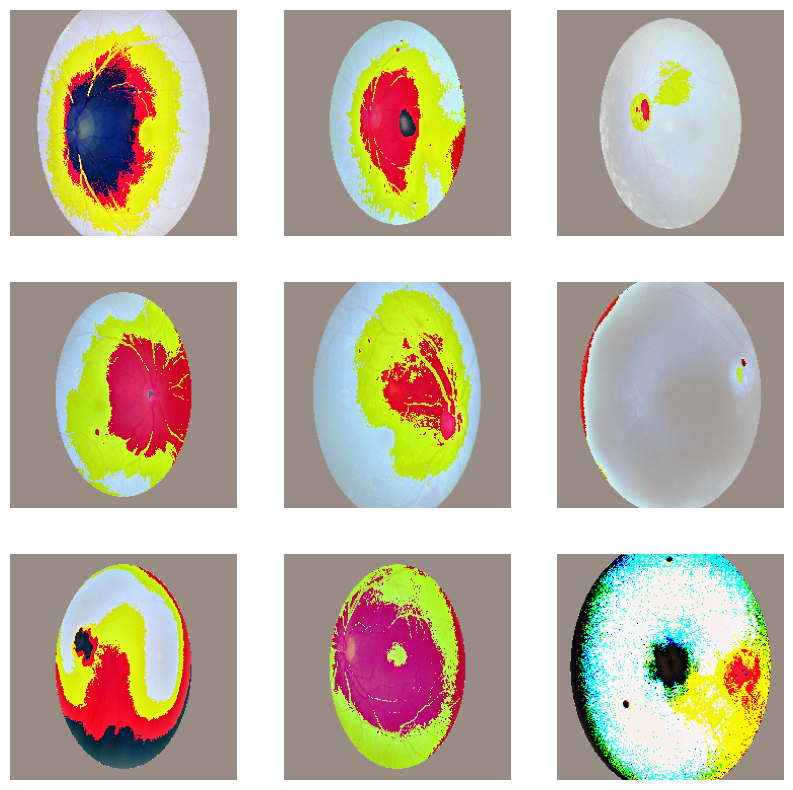

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

# Define the parse_image function
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    return image

# Specify the directory
data_dir = Path('ODIR-5K/')
test_image_paths = list(data_dir.glob('Testing Images/*'))

# Convert the list of image paths to strings (if they're not already)
test_image_paths = [str(path) for path in test_image_paths]

# Create a TensorFlow dataset from the list of image paths
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)

# Map the parse_image function to preprocess the images
test_dataset = test_dataset.map(parse_image)

# Apply batching and prefetching to the dataset
test_dataset = test_dataset.batch(16)  # Batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetching

# Visualize the data
plt.figure(figsize=(10, 10))
for images in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')


In [28]:
print("Size of test dataset: ", len(test_dataset))

Size of test dataset:  63


Making Predictions

63/63 [==============================] - 3s 52ms/step


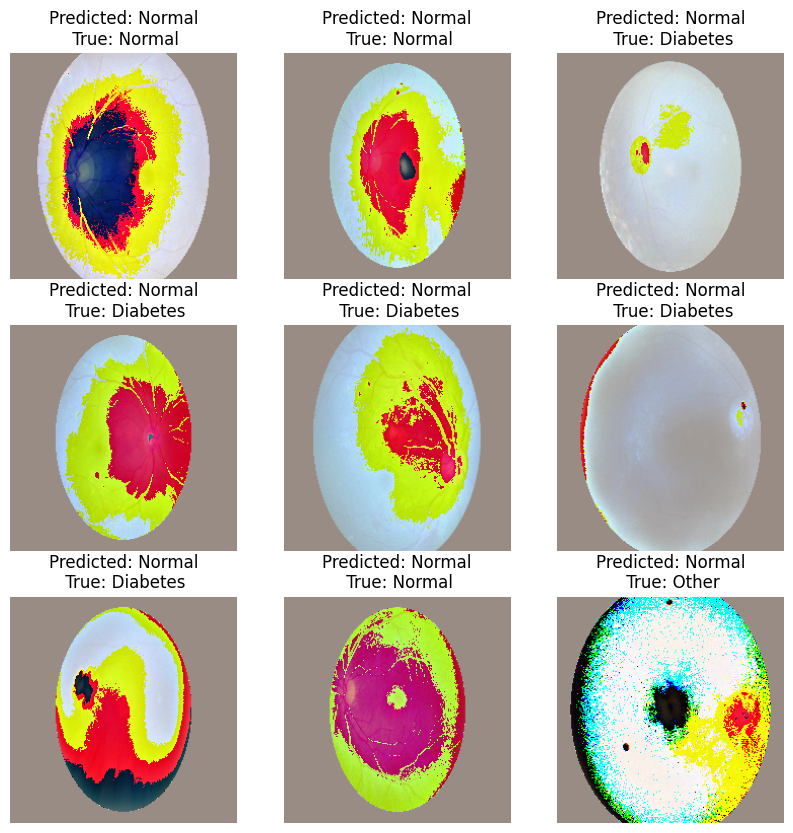

In [29]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

# Generate predictions
predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']


# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(labels[i])]))
    plt.axis("off")

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

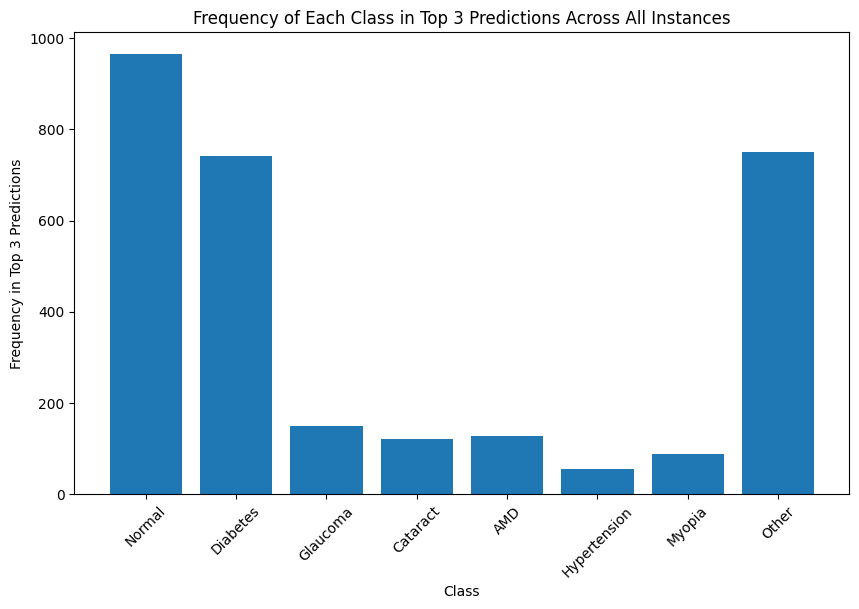

In [32]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [33]:
# Save the model
resnet_50_model.save('base-resnet_50_model')